## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
FACTOR = [0.3, 0.7]
PATIENCE = [10, 20]
OPTIMIZER = [keras.optimizers.RMSprop, keras.optimizers.Adam]

In [9]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
"""
Set model checkpoint callbacks
Write your training loop and show the results
"""
from keras.callbacks import ReduceLROnPlateau

results = {}
for opt in OPTIMIZER:
    for fac in FACTOR:
        for pat in PATIENCE:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print("Experiment with Optimizer = %s, Factor = %.6f, Patience = %.6f " % (str(opt), fac, pat))
            reduce_lr = ReduceLROnPlateau(factor=fac, 
                                          min_lr=1e-12, 
                                          monitor='val_loss', 
                                          patience=pat, 
                                          verbose=1)
            model = build_mlp(input_shape=x_train.shape[1:])
            model.summary()
            optimizer = opt(lr=LEARNING_RATE)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True,
                      callbacks=[reduce_lr]
                     )

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "exp-optimizer-%s-fac-%s-pat-%s" % (str(opt), str(fac), str(pat))
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

Experiment with Optimizer = <class 'keras.optimizers.RMSprop'>, Factor = 0.300000, Patience = 10.000000 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________

50000/50000 [==============================] - 2s 31us/step - loss: 0.1911 - acc: 0.9642 - val_loss: 1.8790 - val_acc: 0.5345
Epoch 48/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1881 - acc: 0.9660 - val_loss: 1.8845 - val_acc: 0.5307
Epoch 49/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1862 - acc: 0.9660 - val_loss: 1.8943 - val_acc: 0.5315
Epoch 50/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1847 - acc: 0.9676 - val_loss: 1.8977 - val_acc: 0.5341
Experiment with Optimizer = <class 'keras.optimizers.RMSprop'>, Factor = 0.300000, Patience = 20.000000 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________

50000/50000 [==============================] - 2s 31us/step - loss: 0.1689 - acc: 0.9632 - val_loss: 2.1460 - val_acc: 0.5147
Epoch 45/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1563 - acc: 0.9668 - val_loss: 2.1311 - val_acc: 0.5070
Epoch 46/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1501 - acc: 0.9682 - val_loss: 2.1633 - val_acc: 0.5091
Epoch 47/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1411 - acc: 0.9717 - val_loss: 2.2579 - val_acc: 0.5059
Epoch 48/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1327 - acc: 0.9741 - val_loss: 2.3073 - val_acc: 0.5005
Epoch 49/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1247 - acc: 0.9765 - val_loss: 2.3806 - val_acc: 0.5088
Epoch 50/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1196 - acc: 0.9773 - val_loss: 2.3956 - val_acc: 0.5012
Experiment with Optimizer = <class 'keras.opti

50000/50000 [==============================] - 2s 32us/step - loss: 0.2462 - acc: 0.9285 - val_loss: 2.2028 - val_acc: 0.4924

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
Epoch 42/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1983 - acc: 0.9500 - val_loss: 2.1880 - val_acc: 0.4941
Epoch 43/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1878 - acc: 0.9529 - val_loss: 2.2277 - val_acc: 0.4956
Epoch 44/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1789 - acc: 0.9566 - val_loss: 2.2817 - val_acc: 0.4989
Epoch 45/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1682 - acc: 0.9596 - val_loss: 2.3496 - val_acc: 0.4937
Epoch 46/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1615 - acc: 0.9614 - val_loss: 2.3888 - val_acc: 0.4975
Epoch 47/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.1531 - acc: 0.9645 -

50000/50000 [==============================] - 2s 32us/step - loss: 0.3943 - acc: 0.8662 - val_loss: 2.7705 - val_acc: 0.3985

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 39/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.3007 - acc: 0.9058 - val_loss: 2.1250 - val_acc: 0.4853
Epoch 40/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2775 - acc: 0.9136 - val_loss: 2.3158 - val_acc: 0.4603
Epoch 41/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.2646 - acc: 0.9181 - val_loss: 2.3866 - val_acc: 0.4699
Epoch 42/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.2510 - acc: 0.9236 - val_loss: 2.2420 - val_acc: 0.4780
Epoch 43/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2361 - acc: 0.9286 - val_loss: 2.5168 - val_acc: 0.4624
Epoch 44/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.2285 - acc: 0.9308 - 

50000/50000 [==============================] - 2s 32us/step - loss: 0.2803 - acc: 0.9368 - val_loss: 1.7387 - val_acc: 0.5174
Epoch 35/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2723 - acc: 0.9399 - val_loss: 1.7603 - val_acc: 0.5141
Epoch 36/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2646 - acc: 0.9432 - val_loss: 1.7481 - val_acc: 0.5175
Epoch 37/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2572 - acc: 0.9451 - val_loss: 1.7505 - val_acc: 0.5161

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 38/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2392 - acc: 0.9548 - val_loss: 1.7521 - val_acc: 0.5225
Epoch 39/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2337 - acc: 0.9566 - val_loss: 1.7507 - val_acc: 0.5211
Epoch 40/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2310 - acc: 0.9579 - 

50000/50000 [==============================] - 2s 34us/step - loss: 0.2653 - acc: 0.9336 - val_loss: 1.8357 - val_acc: 0.4997
Epoch 31/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.2500 - acc: 0.9393 - val_loss: 1.8414 - val_acc: 0.5090
Epoch 32/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.2342 - acc: 0.9451 - val_loss: 1.8527 - val_acc: 0.5083
Epoch 33/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2205 - acc: 0.9489 - val_loss: 1.9194 - val_acc: 0.5118
Epoch 34/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.2100 - acc: 0.9532 - val_loss: 2.0038 - val_acc: 0.4941
Epoch 35/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.1989 - acc: 0.9555 - val_loss: 1.9443 - val_acc: 0.5093
Epoch 36/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.1839 - acc: 0.9611 - val_loss: 2.0306 - val_acc: 0.5058
Epoch 37/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 32us/step - loss: 0.3793 - acc: 0.8776 - val_loss: 2.0867 - val_acc: 0.4616

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epoch 28/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.3015 - acc: 0.9127 - val_loss: 1.9330 - val_acc: 0.4939
Epoch 29/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.2611 - acc: 0.9284 - val_loss: 1.9815 - val_acc: 0.4869
Epoch 30/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2433 - acc: 0.9348 - val_loss: 1.9596 - val_acc: 0.4945
Epoch 31/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2226 - acc: 0.9431 - val_loss: 2.0228 - val_acc: 0.4912
Epoch 32/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2100 - acc: 0.9465 - val_loss: 2.0995 - val_acc: 0.4881
Epoch 33/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.1898 - acc: 0.9537 - 

50000/50000 [==============================] - 2s 32us/step - loss: 0.5015 - acc: 0.8344 - val_loss: 1.7925 - val_acc: 0.4705
Epoch 24/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.4447 - acc: 0.8574 - val_loss: 1.7672 - val_acc: 0.4873
Epoch 25/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.4163 - acc: 0.8666 - val_loss: 1.8853 - val_acc: 0.4723
Epoch 26/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.3888 - acc: 0.8770 - val_loss: 1.9360 - val_acc: 0.4688
Epoch 27/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.3671 - acc: 0.8848 - val_loss: 1.9707 - val_acc: 0.4675
Epoch 28/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.3504 - acc: 0.8888 - val_loss: 2.1272 - val_acc: 0.4703
Epoch 29/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.3248 - acc: 0.8983 - val_loss: 2.2782 - val_acc: 0.4499
Epoch 30/50
50000/50000 [=====================

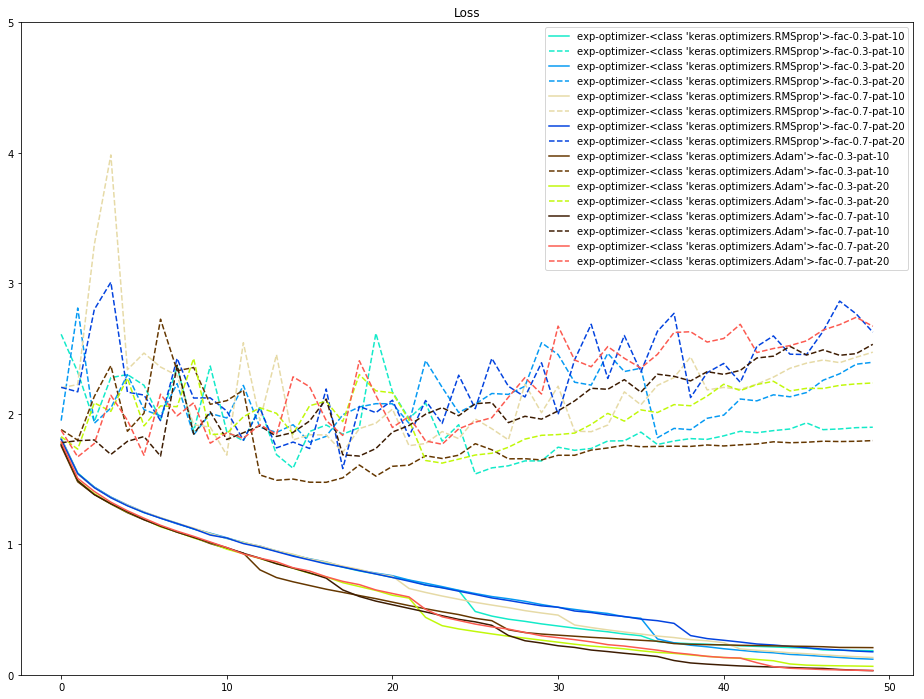

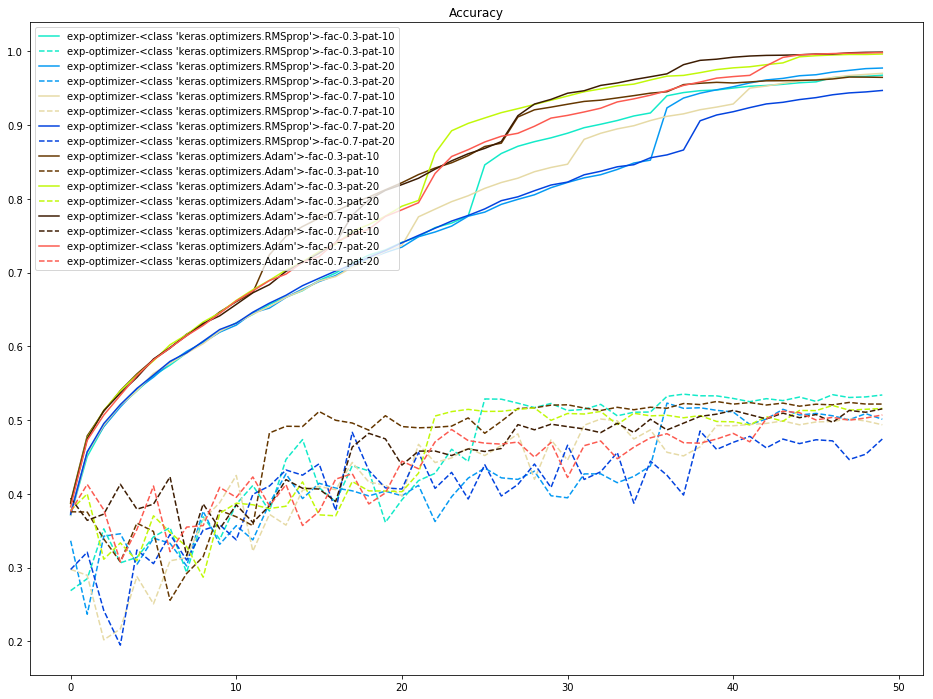

In [10]:
# 繪製結果
"""
plot the results
"""
import matplotlib.pyplot as plt
%matplotlib inline
"""
Plot results
"""
color_bar = ["xkcd:aqua", "xkcd:azure", "xkcd:beige", "xkcd:blue", "xkcd:brown", "xkcd:chartreuse", 
             "xkcd:chocolate", "xkcd:coral", "xkcd:crimson", "xkcd:cyan", "xkcd:darkblue", "xkcd:darkgreen", 
             "xkcd:fuchsia", "xkcd:gold", "xkcd:green", "xkcd:gray", "xkcd:indigo", "xkcd:ivory", 
             "xkcd:khaki", "xkcd:lavender", "xkcd:lightblue", "xkcd:lightgreen", "xkcd:lime", "xkcd:orange"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()